# Modelo de Machine Learning

# Se importan las librerias

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
import nltk
import folium
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from nltk.tokenize import word_tokenize
# Se descarga el recurso 'punkt' para tokenizar o separar palabras
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Se importa el archivo "Metadata ML.csv" que está asociado a 1200 restaurantes de Miami filtrados

In [4]:
meta_2=pd.read_csv("Metadata ML.csv")

### Se importa el archivo "Metadata.csv" que se utilizará para medir el KPI 1

In [5]:
meta=pd.read_csv("Metadata.csv")

In [ ]:
meta.head(2)

,local_name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,apto_sillas_de_ruedas,atmosfera_agradable,apto_grupos_grandes,solo_efectivo,state,City
0,La Pupusa Factory,"La Pupusa Factory, 1947 W Flagler St, Miami, F...",0x88d9b6e36c859cb3:0xa9a5e651a22e92a3,25.772856,-80.227814,Restaurant,3.3,8,0,0,0,0,FL,Miami
1,Subway,"Subway, 8352 Mills Dr, Miami, FL 33183",0x88d9c0c3a05a45df:0xb3d1f93ccfb2da60,25.689864,-80.388096,Restaurant,3.4,26,0,0,0,0,FL,Miami


### Se importan los archivos "data_filtrada.parquet" y "data_reviews.parquet" que posee un gran conjunto de palabras útiles para entrenar el modelo

In [6]:
meta_1=pd.read_parquet("data_filtrada.parquet")

In [7]:
meta_3=pd.read_parquet("data_reviews.parquet")

In [ ]:
meta_3.head(3)

,date,rating,opinion,resp,gmap_id
0,2021-08-03,1,Update: Their “reply” to my review amounted to...,"{""time"": 1627042799532, ""text"": ""Thank you for...",0x8893863ea87bd5dd:0x9383ebf973e74abb
1,2020-07-18,5,He's a knowledgeable doctor but the way he run...,"{""time"": 1582464056733, ""text"": ""Thank you for...",0x8893863ea87bd5dd:0x9383ebf973e74abb
2,2021-04-19,5,The Husband and Wife are so nice and helpful. ...,None,0x88c33f1c8e1f99a3:0x99b22c5bd258b3a7


### Se guardan las categorías únicas de cada dataset, por un lado las categorías del dataset a estudiar, y por oto lado las de los datasets de refuerzo, para entrenar mejor el algoritmo de reconocimiento de palabras

In [8]:
categorias_existentes = meta_1['category'].unique()

In [9]:
categorias_existentes_1 = meta_3['opinion'].unique()

In [10]:
categorias_existentes_2 = meta['category'].unique()

In [ ]:
categorias_existentes_2

array(['Restaurant', 'Bar & grill', 'Cuban restaurant',
       'Pizza restaurant', 'Chinese restaurant', 'Italian restaurant',
       'Mexican restaurant', 'Seafood restaurant', 'American restaurant',
       'Barbecue restaurant', 'Japanese restaurant',
       'Fast food restaurant'], dtype=object)

### Se utiliza el algoritmo KernelDensity que busca la densidad en la coordenadas de los restaurantes

### **KDE:**
El método de Kernel Density Estimation (KDE) se realiza de manera iterativa.

Inicialización: En la primera iteración, KDE comienza con un conjunto de restaurantes, digamos "Restaurantes Iniciales", y asigna una distribución suavizada (en este caso, se usa el kernel gaussiano) alrededor de cada uno de ellos. Esto representa la densidad de restaurantes en esas ubicaciones iniciales.

Iteración: Luego, en cada iteración, KDE considera las ubicaciones de los "Restaurantes Iniciales" y, para cada ubicación, calcula una nueva distribución suavizada que representa la densidad de restaurantes. Esta nueva distribución se suma a las distribuciones previamente calculadas de las iteraciones anteriores.

Ponderación: En cada iteración, las nuevas distribuciones se ponderan según la proximidad a las ubicaciones originales de los "Restaurantes Iniciales". Esto significa que las ubicaciones cercanas a los restaurantes iniciales tendrán una mayor influencia en la distribución final, mientras que las ubicaciones más alejadas tendrán una influencia menor.

Convergencia: El proceso de iteración se repite varias veces hasta que se alcance una convergencia satisfactoria. En otras palabras, cuando las distribuciones ya no cambian significativamente entre iteraciones sucesivas, el algoritmo se detiene.

El resultado final es una representación continua de la densidad de restaurantes en diferentes áreas geográficas, donde las ubicaciones cercanas a los restaurantes iniciales tienen una mayor densidad y las ubicaciones más lejanas tienen una menor densidad.




#####**En este contexto, es esencial señalar que las distancias entre puntos son relativamente cortas. Aunque la métrica euclidiana podría haber sido aplicada con un margen de error mínimo, se optó por la métrica de Haversine que es más precisa y más aproximada a la curvatura de la tierra. Dado que este modelo es general y puede servir para aplicar a distancias mayores, se tuvo en cuenta esta precaución.**

In [11]:
# Se obtienen las coordenadas de todos los restaurantes
coordenadas = meta[['latitude', 'longitude']].values

# Se inicializa el modelo de Kernel Density Estimation (KDE)
kde = KernelDensity(bandwidth=0.01, metric='haversine')

# Se ajusta el modelo a las coordenadas de los restaurantes
kde.fit(np.radians(coordenadas))

# Se calcula las densidades para todas las coordenadas de los restaurantes
densidades = kde.score_samples(np.radians(coordenadas))

# Se agregan la columna de densidad al DataFrame "meta"
meta['densidad'] = densidades


###**Código**
- Se obtienen las coordenadas de todos los restaurantes reales desde el dataframe a estudiar. Estas coordenadas se almacenan en la variable coordenadas.

- Se inicializa el modelo de Kernel Density Estimation (KDE) con un ancho de banda (bandwidth) de 0.01 y una métrica de distancia "haversine". El ancho de banda controla la suavización de la estimación de densidad.

- El modelo de KDE se ajusta a las coordenadas de los restaurantes reales utilizando la función fit.

- Se calcula la densidad para todas las coordenadas de los restaurantes reales utilizando la función score_samples. Esto proporciona una estimación continua de la densidad de restaurantes en función de las ubicaciones geográficas de los restaurantes reales.

### Se cambia el formato de la columna "avg_rating" a numérico

In [12]:
meta['avg_rating'] = pd.to_numeric(meta['avg_rating'], errors='coerce')


### Se entrena un modelo de búsqueda de palabras similares llamado Word2Vec

Objetivo: Word2Vec Continuous Bag of Words (CBOW) ( arquitectura de red neuronal ) busca aprender representaciones vectoriales (vectores de palabras) a partir de un gran conjunto de textos.

Proceso:

- Representación One-Hot: Cada palabra se representa como un vector one-hot (todos ceros, excepto un uno en la posición correspondiente a la palabra).

- Capa Oculta: Utiliza una capa oculta con pesos que se ajustan durante el entrenamiento. Estos pesos forman los vectores de palabras.

- Predicción del Contexto: El modelo intenta predecir las palabras circundantes (contexto) a partir de una palabra central. Usa una función softmax para calcular las probabilidades de contexto.

- Función de Pérdida: La función de pérdida se calcula en la capa de salida, que es la capa final del modelo CBOW. Se compara la predicción del modelo (las probabilidades de las palabras de contexto) con el contexto real del corpus (las palabras de contexto reales). La entropía cruzada es una medida comúnmente utilizada para calcular esta pérdida. La pérdida mide cuán bien se están realizando las predicciones en la capa de salida.

- Optimización de los pesos: Se utiliza el algoritmo del descenso de gradiente, para ajustar los pesos de la capa oculta y mejorar la predicción.

- Iteración: Repite el proceso con diferentes pares de palabras en el corpus para mejorar gradualmente las representaciones vectoriales de las palabras.







**En definitiva, Word2Vec busca un espacio vectorial adecuado para representar un conjunto de palabras, mapeándolas con vectores. Esto lo logra a través de un modelo de redes neuronales, como se explicó brevemente.**

### Se entrenan con palabras para los 3 datasets

In [13]:
# Primer conjunto de datos (categorias_tokenizadas)
categorias_limpio = [re.sub(r'[^\w\s]', '', category) for category in categorias_existentes]
categorias_tokenizadas = [word_tokenize(category) for category in categorias_limpio]

# Segundo conjunto de datos (categorias_existentes_1)
categorias_existentes_1 = [item for item in categorias_existentes_1 if isinstance(item, str)]  # Se filtran cadenas de texto
categorias_limpio_1 = [re.sub(r'[^\w\s]', '', category) for category in categorias_existentes_1]
categorias_tokenizadas_1 = [word_tokenize(category) for category in categorias_limpio_1]

# Tercer conjunto de datos (categorias_existentes_3, este es el dataset a estudiar)
categorias_existentes_2 = [item for item in categorias_existentes_2 if isinstance(item, str)]  # Se filtran cadenas de texto
categorias_limpio_2 = [re.sub(r'[^\w\s]', '', category) for category in categorias_existentes_2]
categorias_tokenizadas_2 = [word_tokenize(category) for category in categorias_limpio_2]

# Se combinan todas las listas de listas de tokens
todos_tokens = categorias_tokenizadas + categorias_tokenizadas_1 + categorias_tokenizadas_2

# Se entrena el modelo Word2Vec en todos los tokens
model = Word2Vec(todos_tokens, vector_size=300, window=5, min_count=5, sg=0)

**Aclaraciones:**
- vector_size=300 es la cantidad de neuronas que recibe la capa oculta.
- windows = 5 significa que toma 5 palabras adyacentes para darle contexto para predecir la palabra central. En definitiva, el parámetro windows controla cuán lejos o cerca se buscan palabras para determinar el contexto de una palabra dada.
- min_count=5 indica la cantidad de veces que deben aparecer las palabras que tomará el algoritmo como mínimo. Si hay menos no las incluye.
- sg=0 es el tipo de modelo que se entrena, en este caso es Continuous Bag of Words (CBOW)

### **Métricas de comparación entre palabras entrenadas por el modelo y palabras que figuran en este dataset a estudiar**

###**Aclaraciones:**
- La similitudes que encuentra el modelo son de carácter semántico, por lo que pueden tener algunas similitudes en el contexto en el que aparecieron en los datos de entrenamiento alrededor de la palabra buscada, lo cual puede ser útil si uno quiere encontrar relaciones implícitas en los datos.

**Métricas a evaluar:**

- **Similitud del coseno** Matemáticamente, se define como el coseno del ángulo entre los dos vectores. Esta fórmula es bien conocida y se calcula mediante el producto escalar de los dos vectores a comparar, ambos normalizados. El resultado varía, por lo tanto, entre -1 y 1. Si da 1 significa que su ángulo es de 0 grados, lo que implicaría un alto grado de similitud vectorial. En cambio, si  da 1, es porque su ángulo es de 90 grados y no hay similitud vectrial alguna. Cabe aclarar que la norma utilizada para normalizar los vectores es la norma 2 ( norma euclidiana ). Las ventajas de esta métrica son:
- La robustez frente a las dimensiones de los vectores, dado que los vectores se normalizan, se relativizan las escalas.
- Capta similitudes angulares de forma implícita. Si bien arroja el coseno del ángulo, esto muestra qué tan cercanos o no son estos vectores en términos de ángulos.

- **Distancia Euclidiana:** Esta métrica mide la distancia directa entre dos puntos en un espacio euclidiano. Cuanto menor sea el valor, más cercanos son los puntos en el espacio. A diferencia de la similitud del coseno, esta métrica tiene en cuenta explícitamente las dimensiones de los vectores, por lo que , mientras más dimensiones tengan los vectores, arrojará resultados numéricos mayores.

In [14]:
# Lista de las primeras palabras que aparecen en el listado de categorías, del dataset que se estudias.
palabras = ["Restaurant", "Bar", "Cuban", "Pizza", "Chinese",
           "Italian", "Mexican", "Seafood", "American",
           "Barbecue", "Japanese", "Fast"]

# Se obtienen todas las palabras en el vocabulario del modelo
palabras_en_modelo = list(model.wv.key_to_index.keys())

# Función para calcular la mejor métrica de similitud para una palabra
def calcular_mejor_metrica(palabra):
    palabra = palabra.strip()  # Se eliminan espacios en blanco al principio y al final

    # Se verifica si la palabra está en el vocabulario del modelo
    if palabra not in palabras_en_modelo:
        return None  # Si la palabra no está en el modelo, retorna None

    mejor_similitud = -1  # Se inicializa la mejor similitud con un valor bajo
    mejor_metrica = None

    # Se calculan métricas para la palabra en comparación con todas las palabras en el modelo
    for palabra_en_modelo in palabras_en_modelo:
        if palabra_en_modelo == palabra:
            continue  # No compara la palabra consigo misma

        vec1 = model.wv[palabra]
        vec2 = model.wv[palabra_en_modelo]

        # Se calcula la similitud de coseno
        cos_similarity = cosine_similarity([vec1], [vec2])[0][0]
        # Se calcula la distancia euclidiana
        euclidean_dist = distance.euclidean(vec1, vec2)

        # Se determina si esta métrica es la mejor hasta ahora
        if cos_similarity > mejor_similitud:
            mejor_similitud = cos_similarity
            mejor_metrica = {
                "palabra1": palabra,
                "palabra2": palabra_en_modelo,
                "cos_similarity": cos_similarity,
                "euclidean_dist": euclidean_dist
            }

    return mejor_metrica

# Se calcula y mostrar las mejores métricas para todas las palabras en la lista
for palabra in palabras:
    mejor_metrica = calcular_mejor_metrica(palabra)
    if mejor_metrica:
        print(f"Mejor aproximación a '{mejor_metrica['palabra1']}': '{mejor_metrica['palabra2']}'")
        print(f"Similitud de Coseno: {mejor_metrica['cos_similarity']}")
        print(f"Distancia Euclidiana: {mejor_metrica['euclidean_dist']}")
        print("=" * 50)



Mejor aproximación a 'Restaurant': 'Deli'
Similitud de Coseno: 0.602918267250061
Distancia Euclidiana: 14.326044082641602
Mejor aproximación a 'Bar': 'Lounge'
Similitud de Coseno: 0.6970359683036804
Distancia Euclidiana: 12.745195388793945
Mejor aproximación a 'Cuban': 'cuban'
Similitud de Coseno: 0.8357378840446472
Distancia Euclidiana: 8.830263137817383
Mejor aproximación a 'Pizza': 'pizza'
Similitud de Coseno: 0.6901898384094238
Distancia Euclidiana: 14.929203033447266
Mejor aproximación a 'Chinese': 'chinese'
Similitud de Coseno: 0.8030151724815369
Distancia Euclidiana: 11.152374267578125
Mejor aproximación a 'Italian': 'italian'
Similitud de Coseno: 0.823211669921875
Distancia Euclidiana: 10.4254789352417
Mejor aproximación a 'Mexican': 'mexican'
Similitud de Coseno: 0.8226906061172485
Distancia Euclidiana: 9.373176574707031
Mejor aproximación a 'Seafood': 'Sushi'
Similitud de Coseno: 0.7641817927360535
Distancia Euclidiana: 7.827583312988281
Mejor aproximación a 'American': 'amer

### **A continuación se comentan algunas similitudes halladas:**

- **'Fast': 'Quick'**Ambas palabras tienen significados similares y a menudo se utilizan indistintamente en ciertos contextos. Por ejemplo, en el contexto de comida rápida, tanto 'Fast' como 'Quick' se utilizan para describir comidas que se preparan y sirven rápidamente.
- **"Seafood" con "Sushi"** : La asociación tiene sentido en términos de similitud semántica, ya que ambas palabras están relacionadas con alimentos marinos. "Seafood" es un término amplio que abarca varios tipos de alimentos que provienen del mar, como pescado, camarones, cangrejos, entre otros. "Sushi" es una variedad específica de comida japonesa que a menudo incluye pescado crudo, por lo que se encuentra dentro de la categoría de "Seafood".
- **"Bar" y "Lounge"** También tiene sentido en términos de similitud semántica. Un "Bar" y un "Lounge" son lugares similares en el sentido de que ambos son establecimientos donde las personas pueden socializar, relajarse y disfrutar de bebidas y picar algo. A menudo, los "Lounge" se asocian con un ambiente más relajado y cómodo, mientras que los "Bares" pueden variar en estilo y ambiente. Esta asociación sugiere que en el corpus de texto utilizado para entrenar el modelo Word2Vec, es común que las palabras "Bar" y "Lounge" aparezcan en contextos relacionados o cerca una de la otra.

### Se guarda el modelo entrenado con el dataset

In [15]:
model.save("modelo_word2vec.bin")

In [16]:
# Se carga el modelo y los archivos auxiliares
# model = Word2Vec.load('modelo_word2vec.bin')
# model.wv.vectors = model.wv.vectors.astype('float32') # se cambian a formato float32
# model.wv.init_sims(replace=True)  # se normalizan para ahorrar memoria


### Se prueba el algoritmo entrenado

**Aclaraciones:**
- Se utiliza el modelo entrenado en los pasos anteriores.
- Una vez ingresada la palabra por el usuario, utiliza el método de similitud del coseno para hallar similitudes.
- Además de filtrar por el reconocimiento del modelo, también se busca la palabra que el usuario ingresó literalmente, para favorecer la búsqueda.
- Es ideal que por un lado se muestren los resultados de similitudes y relación presentadas por el algoritmo, así como también la búsqueda de la palabra que literalmente ingresó el usuario, para mejorar y personalizar la búsqueda.

In [17]:
# Se obtiene la palabra ingresada por el usuario
palabra = input("Ingresa una palabra: ")

# Se limpia la palabra ingresada por el usuario
palabra = re.sub(r'[^\w\s]', '', palabra)

# Se entrena la palabra más cercana según la similitud del coseno
try:
    palabra_similar, similaridad = model.wv.most_similar(palabra, topn=1)[0]
    print(f"además de '{palabra}' se sugiere buscar '{palabra_similar}' con una similitud de coseno de {similaridad:.2f}")

    # Se filtra las categorías que contienen la palabra similar
    categorias_con_palabra = [categoria for categoria in categorias_existentes if palabra_similar in categoria]

    # Se filtra el DataFrame 'meta' por las categorías encontradas
    meta_filtro = meta[meta['category'].isin(categorias_con_palabra)]

    # También se filtra por restaurantes que contengan la palabra buscada en la columna 'category'
    restaurantes_con_palabra = meta[meta['category'].str.contains(palabra, case=False)]

    # Se concatena la palabra ingresada por el usuario a la lista de palabras similares
    palabras_similares = [palabra_similar] if palabra_similar else []
    palabras_similares.append(palabra)

    # Se agrega la palabra literalmente ingresada por el usuario al DataFrame
    palabra_df = pd.DataFrame({'category': [palabra]*len(restaurantes_con_palabra)})
    meta_filtro = pd.concat([meta_filtro, restaurantes_con_palabra, palabra_df])

except KeyError:
    print(f"'{palabra}' no se ha logrado encontrar alguna asociación con la palabra ingresada.")


Ingresa una palabra: Italian
además de 'Italian' se sugiere buscar 'italian' con una similitud de coseno de 0.82


**Funcionamiento del código:**
- El usuario ingresa una palabra y se asegura de que esté limpia de caracteres no deseados.
- Luego, utiliza el modelo de Word Embeddings (model.wv) para encontrar la palabra más cercana en términos de similitud de coseno a la palabra ingresada por el usuario.
- Filtra las categorías que contienen la palabra similar encontrada.
- Filtra el DataFrame meta por categorías relacionadas y también por restaurantes que contienen la palabra buscada en la columna 'category'.
- Concatena la palabra similar encontrada y la palabra ingresada por el usuario a la lista de palabras similares.
- Agrega la palabra ingresada por el usuario al DataFrame meta_filtro.

### **Ensamble**: Se utiliza el algoritmo entrenado para mostrar los restaurantes más recomendados, utilizando la optimización de una suma ponderada, que vincula las características "densidad" "puntaje" y "número de reviews" con el metodo del descenso del gradiente

### **Función a optimizar**:

### puntuación restaurante = peso_puntaje * puntaje_normalizado + peso_densidad * densidad_normalizada + peso_nºreviews * nº_reviews_normalizado

### **A continuación se utiliza el método de optimización SLSQP, para ptimizar los pesos donde, en este caso sólo se impone la restricción de que estos sean positivos.**

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: -3.2646059038187353e+34
            Iterations: 48
            Function evaluations: 192
            Gradient evaluations: 48
Pesos Optimizados:
Peso 1: 9.567500927301737e+32
Peso 2: 1.1360371443669498e+33
Peso 3: 9.057960997245599e+31
Número de iteraciones realizadas: 48


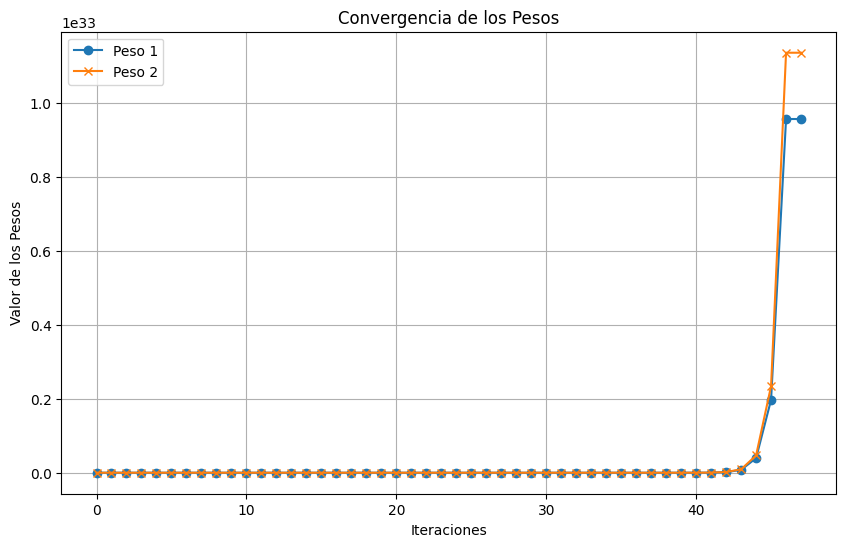

In [56]:
# Seleccionar las columnas que se van a normalizar
columnas_a_normalizar = ['avg_rating', 'densidad', 'num_of_reviews']

# Copiar los datos originales para mantener los valores sin normalizar
datos_normalizados = meta_filtro.copy()

# Normalizar las columnas una por una
for columna in columnas_a_normalizar:
    # Crear un escalador para la columna actual
    escalador = MinMaxScaler(feature_range=(0, 1))
    # Añadir una nueva columna con los valores normalizados
    datos_normalizados[f'{columna}_normalizado'] = escalador.fit_transform(meta_filtro[[columna]])

# Pesos iniciales en el rango [0, 1]
pesos_iniciales = [0.25, 0.25, 0.25]  # Valores iniciales de los pesos

# Definir la función objetivo para minimizar
def funcion_objetivo(pesos):
    puntuacion_restaurante = (
        pesos[0] * datos_normalizados['densidad_normalizado'] +
        pesos[1] * datos_normalizados['avg_rating_normalizado'] +
        pesos[2] * datos_normalizados['num_of_reviews_normalizado']
    )
    return -puntuacion_restaurante.sum()

# Definir las restricciones de los pesos (en este caso, positivos)
restricciones = [{'type': 'ineq', 'fun': lambda w: w[i]} for i in range(len(pesos_iniciales))]

# Definir la tolerancia para la convergencia
tolerancia = 1e-6

# Definir las opciones para el algoritmo
opciones = {'disp': True, 'gtol': tolerancia}

# Variables para almacenar los valores de los dos primeros pesos durante las iteraciones
historial_pesos = []

# Función para capturar los valores de los dos primeros pesos en cada iteración
def capturar_pesos(x):
    historial_pesos.append((x[0], x[1]))

# Optimizar los pesos usando el algoritmo de Descenso del Gradiente con las opciones definidas
resultado = minimize(funcion_objetivo, pesos_iniciales, constraints=restricciones, options=opciones, callback=capturar_pesos)

# Obtener los pesos optimizados
pesos_optimizados = resultado.x

# Calcular la puntuación_restaurante con los pesos optimizados
datos_normalizados['puntuacion_restaurante'] = (
    pesos_optimizados[0] * datos_normalizados['densidad_normalizado'] +
    pesos_optimizados[1] * datos_normalizados['avg_rating_normalizado'] +
    pesos_optimizados[2] * datos_normalizados['num_of_reviews_normalizado']
)

# Redondear los valores a 7 decimales
datos_normalizados['puntuacion_restaurante'] = datos_normalizados['puntuacion_restaurante'].round(7)

# Ordenar el DataFrame en función de la puntuación restaurante en orden decreciente
datos_ordenados = datos_normalizados.sort_values(by='puntuacion_restaurante', ascending=False)

# Imprimir los pesos optimizados
print("Pesos Optimizados:")
for i, peso in enumerate(pesos_optimizados, start=1):
    print(f"Peso {i}: {peso}")

# Imprimir el número de iteraciones realizadas
print(f"Número de iteraciones realizadas: {resultado.nit}")

# Extraer los valores de los dos primeros pesos para el gráfico de convergencia
peso1_historial, peso2_historial = zip(*historial_pesos)

# Gráfico de convergencia de los dos primeros pesos
plt.figure(figsize=(10, 6))
plt.plot(peso1_historial, label='Peso 1', marker='o')
plt.plot(peso2_historial, label='Peso 2', marker='x')
plt.xlabel('Iteraciones')
plt.ylabel('Valor de los Pesos')
plt.legend()
plt.title('Convergencia de los Pesos')
plt.grid(True)
plt.show()




**Aclaraciones**:
- Las categorías "densidad", "puntaje" y "nº de reviews" se reescalan entre 0 y 1. No se utilizó z-score porque las distribuciones de los datos no son normales.
- Los pesos sólo tienen la restricción de ser valores positivos.
- En base a la palabra clave que ingresó el usuario, se mostrarán qué características son las mejores puntuadas de forma intrínseca en el conjunto de datos. Por ejemplo, si resalta más la característica "puntaje" respecto de las otras, significa que predominan los buenos puntajes frente a la densidad y al nº de reviews, para este subconjunto de datos.

**Aclaración**: Como se puede observar, orden de importancia de las características varía de acuerdo a la elección de palabra hecha por el usuario. Probablemente, para otra elección de categoría se obtenga otro orden de importancia de las características.

**Se observa que el orden de iportancia de los pesos es el mismo que el utilizado en el método anterior**

In [67]:
meta_ordenado.head(3)

,local_name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,apto_sillas_de_ruedas,atmosfera_agradable,apto_grupos_grandes,solo_efectivo,state,City,densidad,avg_rating_normalized,densidad_normalized,num_of_reviews_normalized,puntuacion_restaurante
322,MONALISA PIZERIA ITALIAN RESTAURANT,"MONALISA PIZERIA ITALIAN RESTAURANT, 4753 SW 8...",0x88d9b7586c7923a5:0xa13568758d12b078,25.764368,-80.272756,Italian restaurant,4.8,25.0,1.0,1.0,1.0,0.0,FL,Miami,7.354743,0.950,1.000000,0.009930,2.036885e+33
325,Caffé Paradiso Miami,"Caffé Paradiso Miami, 114 NE 20th Terrace, Mia...",0x88d9b7d591e60669:0xd36cf00540e1407d,25.795828,-80.192323,Italian restaurant,5.0,2.0,1.0,1.0,1.0,0.0,FL,Miami,7.343521,1.000,0.829463,0.000414,1.929663e+33
860,Casa Tua Cucina,"Casa Tua Cucina, 70 SW 7th St, Miami, FL 33130...",0x88d9b684949c6fa1:0x5da9b5c4bd240d6b,25.767178,-80.194322,Italian restaurant,4.5,2418.0,1.0,1.0,1.0,0.0,FL,Miami,7.345700,0.875,0.862582,1.000000,1.909887e+33


### Se corrobora la independencia de las características utilizadas. Esto es importante para descartar características que puedan estar de más y sesgar el modelo

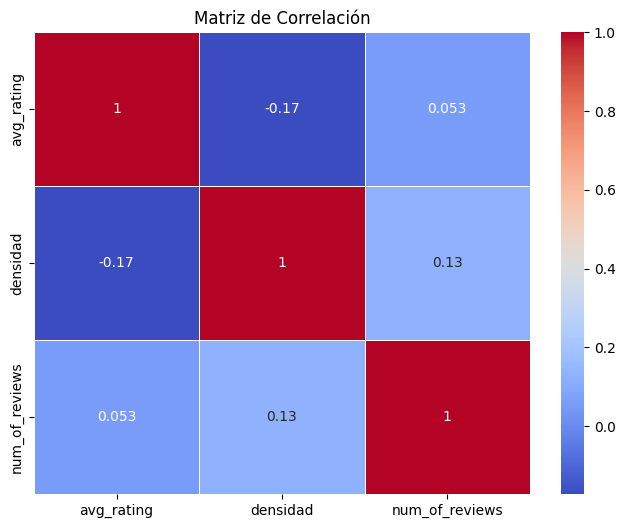

In [58]:
# Se calcula la matriz de correlación
corr = meta_ordenado[['avg_rating', 'densidad', 'num_of_reviews']].corr()

# Se crea un mapa de calor (heatmap) para visualizar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

### Se observa la correlación entre la puntuación de los restaurantes filtrados y cada característica usada

In [59]:
# Calcula las correlaciones entre "puntuacion_restaurante" y las tres columnas normalizadas
correlation_puntaje = meta_ordenado['puntuacion_restaurante'].corr(meta_ordenado['avg_rating'])
correlation_densidad = meta_ordenado['puntuacion_restaurante'].corr(meta_ordenado['densidad'])
correlation_reviews = meta_ordenado['puntuacion_restaurante'].corr(meta_ordenado['num_of_reviews'])

print(f"Correlación entre Puntuación del Restaurante y Puntaje Normalizado: {correlation_puntaje}")
print(f"Correlación entre Puntuación del Restaurante y Densidad Normalizada: {correlation_densidad}")
print(f"Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: {correlation_reviews}")


Correlación entre Puntuación del Restaurante y Puntaje Normalizado: 0.6938358594139046
Correlación entre Puntuación del Restaurante y Densidad Normalizada: 0.5868941097365156
Correlación entre Puntuación del Restaurante y Número de Reseñas Normalizado: 0.19595865037084498


### Se Una vez que el usuario seleccionó el restaurante que quiere examinar, se buscan los que están alrededor de este

In [68]:
from geopy.distance import geodesic

# Se ingresa la entrada del usuario
nombre_ingresado = input("Ingrese el nombre del lugar: ")

# Se filtran los datos para obtener solo los restaurantes dentro del radio de 500 metros
restaurantes_cercanos = meta_2.copy()

# Se definen las coordenadas del lugar ingresado por el usuario
latitud_usuario = restaurantes_cercanos[restaurantes_cercanos['local_name'] == nombre_ingresado]['latitude'].iloc[0]
longitud_usuario = restaurantes_cercanos[restaurantes_cercanos['local_name'] == nombre_ingresado]['longitude'].iloc[0]

# Se calcula la distancia (euclidiana, las distancias son cortas) a cada restaurante en metros y agregarla como una nueva columna
restaurantes_cercanos['Distancia (m)'] = restaurantes_cercanos.apply(
    lambda row: geodesic((latitud_usuario, longitud_usuario), (row['latitude'], row['longitude'])).meters, axis=1
)

# Se convierte la distancia límite a un valor numérico (en metros)
distancia_limite_metros = 500

# Se filtran los restaurantes dentro del radio de 500 metros y con la misma categoría
restaurantes_cercanos = restaurantes_cercanos[
    (restaurantes_cercanos['Distancia (m)'] <= distancia_limite_metros)
]

# Se ordenan los restaurantes por distancia
restaurantes_cercanos = restaurantes_cercanos.sort_values(by='Distancia (m)')



Ingrese el nombre del lugar: Caffé Paradiso Miami


### Se visualizan los resultados en una tabla

In [65]:
columnas=["local_name","category","Distancia (m)"]

In [69]:
restaurantes_cercanos[columnas]

,local_name,category,Distancia (m)
132,Caffé Paradiso Miami,Italian restaurant,0.000000
988,BOHO Miami,Restaurant,16.397498
143,Mr Ceviche Peruvian Restaurant,"Peruvian restaurant, Latin American restaurant",354.562831
935,Salad Creations,Restaurant,359.450916
118,The Seafood Bar & Market,Restaurant,359.592704
882,The Daily Creative Food Co.,"Restaurant, Breakfast restaurant, Caterer, Din...",365.309914
386,Fuel Poke,Hawaiian restaurant,398.419871
64,GALIPAN Bistro,"Fast food restaurant, Hamburger restaurant, Ve...",418.903552
323,Alidoro,"Sandwich shop, Italian restaurant",444.817316
787,Plant Food + Wine,"Vegan restaurant, Organic restaurant, Restaurant",478.049918


### Se genera un mapa para visualizar

In [70]:
# Se crea un mapa centrado en las coordenadas del usuario
mapa = folium.Map(location=[latitud_usuario, longitud_usuario], zoom_start=15)

# Se itera a través de los restaurantes cercanos y agrega marcadores rojos al mapa
for index, restaurante in restaurantes_cercanos.iterrows():
    folium.Marker(
        location=[restaurante['latitude'], restaurante['longitude']],
        popup=restaurante['local_name'],  # Puedes personalizar el contenido emergente
        icon=folium.Icon(color='red')
    ).add_to(mapa)

# Se guarda el mapa como un archivo HTML
mapa.save('restaurantes_cercanos_mapa.html')

### Se guarda un archivo csv con los restaurantes de esa zona para calcular el KPI 1 y presentarlo en el dashboard

In [71]:
restaurantes_cercanos.to_csv('Archivo.csv', index=False)